# Flujo Óptico

Alejandro Jesús González Santana

## Hipótesis

Se realizará una comparación del rendimiento en la detección de desplazamientos de objetos entre dos frames utilizando la base de datos Flying Chairs. Los métodos que se emplearán son:
- Farneback
- RAFT

Los resultados del flujo óptico se representarán en un mapa de colores que describa los movimientos y se compararán con el ground truth de las imágenes originales.

In [18]:
from torchvision.models.optical_flow import raft_large, raft_small
import cv2 as cv
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T
from pathlib import Path
from urllib.request import urlretrieve

## Lectura de imágenes

Trabajaremos con las imágenes 00001 y 00004 de la base de datos Flying Chairs (descargadas desde el campus virtual) para realizar una comparación de ground truth entre dos algoritmos: Farneback y RAFT Small.

In [19]:
import cv2 as cv

img1_00001 = cv.imread(r'Ejemplos de la base de datos Flying Chairs-20241212\00001_img1.ppm')
img2_00001 = cv.imread(r'Ejemplos de la base de datos Flying Chairs-20241212\00001_img2.ppm')

img1_00004 = cv.imread(r'Ejemplos de la base de datos Flying Chairs-20241212\00004_img1.ppm')
img2_00004 = cv.imread(r'Ejemplos de la base de datos Flying Chairs-20241212\00004_img2.ppm')

#ver imagenes
#cv.imshow('Imagen 1_00001', img1_00001)
#cv.imshow('Imagen 2_00001', img2_00001)
#cv.imshow('Imagen 1_00002', img1_00004)
#cv.imshow('Imagen 2_00002', img2_00004)
#cv.waitKey(0)
#cv.destroyAllWindows()


## RAFT

Los lotes de imágenes se procesarán utilizando la función preprocess, que fue obtenida del ejemplo de la práctica. Los datos de las imágenes se convertirán a torch.float32 y se normalizarán utilizando una media de 0.5 y una desviación estándar de 0.5, lo que cambia la escala de los valores de -1 a 1. La función de plot se utilizará para visualizar los resultados de la predicción.

En primer lugar, es importante recordar que RAFT es una técnica de deep learning basada en redes, por lo que es necesario leer las imágenes como tensores. La función load_image_as_tensor se encarga de esta conversión. Esta función lee las imágenes a color, las convierte a escala de grises y finalmente las transforma en un tensor, reordenando las dimensiones a (canales, alto, ancho), que es el formato que espera RAFT. Los valores de los píxeles se normalizan dividiendo entre 255, aunque esta parte podría ser redundante, ya que la función preprocess también maneja esta normalización.

Una vez leídas las imágenes con esta función, las apilamos en dos lotes. El primer lote contiene los frames previos al movimiento, mientras que el segundo contiene las imágenes desplazadas. Ambas imágenes en cada lote se preprocesan utilizando la función preprocess.

In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T
from pathlib import Path
from urllib.request import urlretrieve
import cv2

def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),
        ]
    )
    batch = transforms(batch)
    return batch

plt.rcParams["savefig.bbox"] = "tight"

def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Hace una matriz
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()


def load_image_as_tensor(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0  # [C, H, W]
    return img_tensor

img1_00001 = load_image_as_tensor(r'Ejemplos de la base de datos Flying Chairs-20241212\00001_img1.ppm')
img2_00001 = load_image_as_tensor(r'Ejemplos de la base de datos Flying Chairs-20241212\00001_img2.ppm')

img1_00004 = load_image_as_tensor(r'Ejemplos de la base de datos Flying Chairs-20241212\00004_img1.ppm')
img2_00004 = load_image_as_tensor(r'Ejemplos de la base de datos Flying Chairs-20241212\00004_img2.ppm')


img1_batch = torch.stack([img1_00001, img1_00004])
img2_batch = torch.stack([img2_00001, img2_00004])

img1_batch = preprocess(img1_batch)
img2_batch = preprocess(img2_batch)



En esta sección, cargamos el modelo preentrenado de RAFT pequeño en la GPU, utilizándolo en modo evaluación. Llamamos al modelo con el lote de los frames previos en primer lugar, seguido de los frames desplazados. Esto nos proporciona una lista de mapas de predicciones de flujo. Nos quedaremos únicamente con el último elemento de la lista, ya que el resto de las predicciones corresponden a estimaciones intermedias que el modelo genera durante el proceso de evaluación y ajuste del resultado.

In [28]:
from torchvision.models.optical_flow import raft_large, raft_small

device = "cuda" if torch.cuda.is_available() else "cpu"

model = raft_small(pretrained=True, progress=False).to(device)
model.eval()


list_of_flows = model(img1_batch.to(device), img2_batch.to(device))

predicted_flows = list_of_flows[-1]

c:\ProgramData\miniconda3\envs\piav\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\miniconda3\envs\piav\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Small_Weights.C_T_V2`. You can also use `weights=Raft_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


En el siguiente código, vemos como se muestran las imágenes con movimiento y su ground truth predicho. En color podemos ver los elementos que se han movido, en este caso solo se mueven las sillas. 

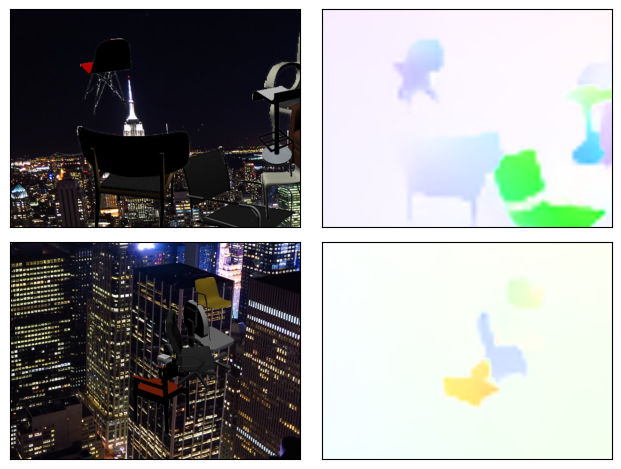

In [29]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]

plot(grid, figsize=(10, 5))

En este fragmento de código, se transfieren las imágenes a la CPU para poder acceder a ellas de forma independiente y manipular las predicciones de flujo óptico. Luego, las dimensiones de las imágenes se ajustan para adaptarse al formato requerido por matplotlib, permitiendo una representación visual correcta de las imágenes de flujo.

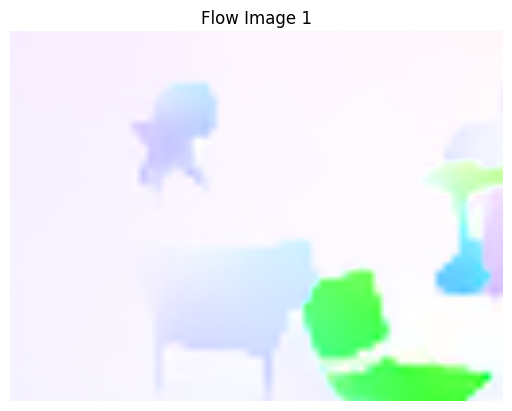

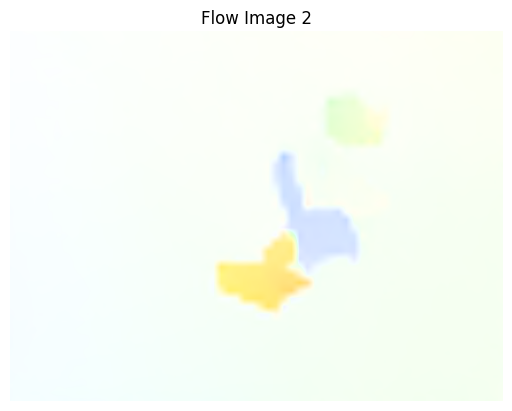

In [37]:
flow_imgs_cpu = flow_imgs.to("cpu")

for i, flow_img in enumerate(flow_imgs_cpu):
    plt.figure()
    plt.imshow(flow_img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Flow Image {i + 1}")
    plt.show()

## Leer Ground Truths verdaderos

Para leer los ground truth reales, se utiliza el formato .flo, empleado por Middlebury para representar estos datos. La página de Middlebury proporciona códigos en C++ para leer estos archivos como un mapa de color. Sin embargo, dado que estos códigos están escritos en C++, se recurre a un script de Python disponible en el repositorio de GitHub de Johannes Oswald, de la Universidad Técnica de Múnich, para poder leer los archivos .flo. El código se encuentra en el siguiente enlace: https://github.com/Johswald/flow-code-python/blob/master/readFlowFile.py.

In [ ]:
import numpy as np
import os

TAG_FLOAT = 202021.25

def read(file):

    assert type(file) is str, "file is not str %r" % str(file)
    assert os.path.isfile(file) is True, "file does not exist %r" % str(file)
    assert file[-4:] == '.flo', "file ending is not .flo %r" % file[-4:]
    f = open(file, 'rb')
    flo_number = np.fromfile(f, np.float32, count=1)[0]
    assert flo_number == TAG_FLOAT, 'Flow number %r incorrect. Invalid .flo file' % flo_number
    w = np.fromfile(f, np.int32, count=1)[0]  # Tomamos el valor escalar de w
    h = np.fromfile(f, np.int32, count=1)[0]  # Tomamos el valor escalar de h
    data = np.fromfile(f, np.float32, count=2 * w * h)  # Usamos los valores escalares de w y h
    flow = np.resize(data, (h, w, 2))  # Reshape de los datos
    f.close()

    return flow

flow = read(r'Ejemplos de la base de datos Flying Chairs-20241212\00001_flow.flo')

In [3]:
import cv2
import sys
import numpy as np
import argparse

def makeColorwheel():

	#  color encoding scheme

	#   adapted from the color circle idea described at
	#   http://members.shaw.ca/quadibloc/other/colint.htm

	RY = 15
	YG = 6
	GC = 4
	CB = 11
	BM = 13
	MR = 6

	ncols = RY + YG + GC + CB + BM + MR

	colorwheel = np.zeros([ncols, 3]) # r g b

	col = 0

	colorwheel[0:RY, 0] = 255
	colorwheel[0:RY, 1] = np.floor(255*np.arange(0, RY, 1)/RY)
	col += RY


	colorwheel[col:YG+col, 0]= 255 - np.floor(255*np.arange(0, YG, 1)/YG)
	colorwheel[col:YG+col, 1] = 255;
	col += YG;


	colorwheel[col:GC+col, 1]= 255 
	colorwheel[col:GC+col, 2] = np.floor(255*np.arange(0, GC, 1)/GC)
	col += GC;


	colorwheel[col:CB+col, 1]= 255 - np.floor(255*np.arange(0, CB, 1)/CB)
	colorwheel[col:CB+col, 2] = 255
	col += CB;


	colorwheel[col:BM+col, 2]= 255 
	colorwheel[col:BM+col, 0] = np.floor(255*np.arange(0, BM, 1)/BM)
	col += BM;


	colorwheel[col:MR+col, 2]= 255 - np.floor(255*np.arange(0, MR, 1)/MR)
	colorwheel[col:MR+col, 0] = 255
	return 	colorwheel

def computeColor(u, v):

	colorwheel = makeColorwheel();
	nan_u = np.isnan(u)
	nan_v = np.isnan(v)
	nan_u = np.where(nan_u)
	nan_v = np.where(nan_v) 

	u[nan_u] = 0
	u[nan_v] = 0
	v[nan_u] = 0 
	v[nan_v] = 0

	ncols = colorwheel.shape[0]
	radius = np.sqrt(u**2 + v**2)
	a = np.arctan2(-v, -u) / np.pi
	fk = (a+1) /2 * (ncols-1)
	k0 = fk.astype(np.uint8)
	k1 = k0+1;
	k1[k1 == ncols] = 0
	f = fk - k0

	img = np.empty([k1.shape[0], k1.shape[1],3])
	ncolors = colorwheel.shape[1]
	for i in range(ncolors):
		tmp = colorwheel[:,i]
		col0 = tmp[k0]/255
		col1 = tmp[k1]/255
		col = (1-f)*col0 + f*col1
		idx = radius <= 1
		col[idx] = 1 - radius[idx]*(1-col[idx]) # increase saturation with radius    
		col[~idx] *= 0.75 # out of range
		img[:,:,2-i] = np.floor(255*col).astype(np.uint8)

	return img.astype(np.uint8)


def computeImg(flow):

	eps = sys.float_info.epsilon
	UNKNOWN_FLOW_THRESH = 1e9
	UNKNOWN_FLOW = 1e10

	u = flow[: , : , 0]
	v = flow[: , : , 1]

	maxu = -999
	maxv = -999

	minu = 999
	minv = 999

	maxrad = -1
	#fix unknown flow
	greater_u = np.where(u > UNKNOWN_FLOW_THRESH)
	greater_v = np.where(v > UNKNOWN_FLOW_THRESH)
	u[greater_u] = 0
	u[greater_v] = 0
	v[greater_u] = 0 
	v[greater_v] = 0

	maxu = max([maxu, np.amax(u)])
	minu = min([minu, np.amin(u)])

	maxv = max([maxv, np.amax(v)])
	minv = min([minv, np.amin(v)])
	rad = np.sqrt(np.multiply(u,u)+np.multiply(v,v)) 
	maxrad = max([maxrad, np.amax(rad)])
	print('max flow: %.4f flow range: u = %.3f .. %.3f; v = %.3f .. %.3f\n' % (maxrad, minu, maxu, minv, maxv))

	u = u/(maxrad+eps)
	v = v/(maxrad+eps)
	img = computeColor(u, v)
	return img

La función de get_ground_truth_from_flo, lee el flujo del archivo .flo y se encarga de computar los flujos en un mapa de color.

In [16]:
def get_ground_truth_from_flo(flo_file):
    flow = read(flo_file)
    truerange = 1
    height = flow.shape[0]

    s2 = int(round(height/2))

    u = flow[: , : , 0]
    v = flow[: , : , 1]		

    img = computeColor(u/truerange, v/truerange)

    img[s2,:,:] = 0
    img[:,s2,:] = 0

    return img

Se leen los archivos de ground truth correspondientes a las imágenes 00001 y 00004, los cuales contienen el mapa de color de los desplazamientos verdaderos de las sillas en la imagen. Estos archivos servirán como referencia para comparar los resultados obtenidos con los métodos Farneback y RAFT.

In [38]:
flow_images_original = []

img_00001_ground_truth = get_ground_truth_from_flo(r'Ejemplos de la base de datos Flying Chairs-20241212\00001_flow.flo')
img_00004_ground_truth = get_ground_truth_from_flo(r'Ejemplos de la base de datos Flying Chairs-20241212\00004_flow.flo')

flow_images_original.append(img_00001_ground_truth)
flow_images_original.append(img_00004_ground_truth)


## Farneback

Para el uso de Farneback, se utilizó como referencia el código de ejemplo disponible en la página oficial de OpenCV (https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html). La función apply_farneback toma como argumentos las dos imágenes que se desean comparar: el frame previo y el actual. Ambas imágenes se convierten a escala de grises y se crea una imagen HSV vacía para almacenar el flujo óptico, con el mismo tamaño que el frame previo.

HSV es un espacio de color que se define por tres componentes: Tono (Hue), Saturación (Saturation) y Brillo (Value). El Tono representa el color como un valor de ángulo de 0 a 360 grados, la Saturación indica la distancia al eje de brillo negro-blanco y varía de 0% a 100% (controla la intensidad del color), y el Brillo representa la luminosidad, con valores de 0 (negro) a 255 (máxima luminosidad). Inicialmente, se asigna la saturación máxima (255, equivalente al 100%) a todos los valores.

A continuación, con las imágenes de entrada, se calcula el flujo óptico utilizando la función calcOpticalFlowFarneback, que recibe las dos imágenes. Los componentes de desplazamiento en los ejes x e y se transforman en coordenadas polares mediante la función cartToPolar. El tono del flujo se asigna en función de la dirección del desplazamiento, lo que permite distinguir visualmente las direcciones del flujo óptico. Es importante que el ángulo se convierta de radianes a grados para obtener el valor del tono. La magnitud del desplazamiento se utiliza para controlar el brillo, normalizando los valores en una escala de 0 a 255, lo que permite que los desplazamientos mayores se representen con un brillo más intenso. Finalmente, la representación en HSV se convierte a BGR (Blue, Green, Red) para que sea visualizable con OpenCV.

Las imágenes de flujo resultantes se almacenan en la lista flow_images_farneback.

Fuente HSV: https://es.wikipedia.org/wiki/Modelo_de_color_HSV

In [46]:
import numpy as np
import cv2 as cv

img1_00001 = cv.imread(r'Ejemplos de la base de datos Flying Chairs-20241212\00001_img1.ppm')
img2_00001 = cv.imread(r'Ejemplos de la base de datos Flying Chairs-20241212\00001_img2.ppm')

img1_00004 = cv.imread(r'Ejemplos de la base de datos Flying Chairs-20241212\00004_img1.ppm')
img2_00004 = cv.imread(r'Ejemplos de la base de datos Flying Chairs-20241212\00004_img2.ppm')


def apply_farneback(prev, next):
    prvs = cv.cvtColor(prev, cv.COLOR_BGR2GRAY)
    hsv = np.zeros_like(prev)
    hsv[..., 1] = 255

    next = cv.cvtColor(next, cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)

    cv.imshow('frame2', bgr)
    cv.waitKey(0)
    cv.destroyAllWindows()

    return bgr


bgr_img_00001 = apply_farneback(img1_00001, img2_00001)
bgr_img_00004 = apply_farneback(img1_00004, img2_00004)

flow_images_farneback = []

flow_images_farneback.append(bgr_img_00001)
flow_images_farneback.append(bgr_img_00004)

## Comparación de resultados

Para visualizar las imágenes, se crea una figura de matplotlib con 3 filas y 2 columnas. Las filas representan los métodos utilizados y los desplazamientos verdaderos, mientras que las columnas corresponden a las imágenes 00001 y 00004. Se itera dos veces para acceder a cada imagen predicha: la primera iteración corresponde a la imagen 00001 y la segunda a la imagen 00004.

Las listas que contienen las imágenes son las siguientes:

- Farneback: flow_images_farneback
- RAFT: flow_imgs_cpu
- Desplazamientos verdaderos: flow_images_original

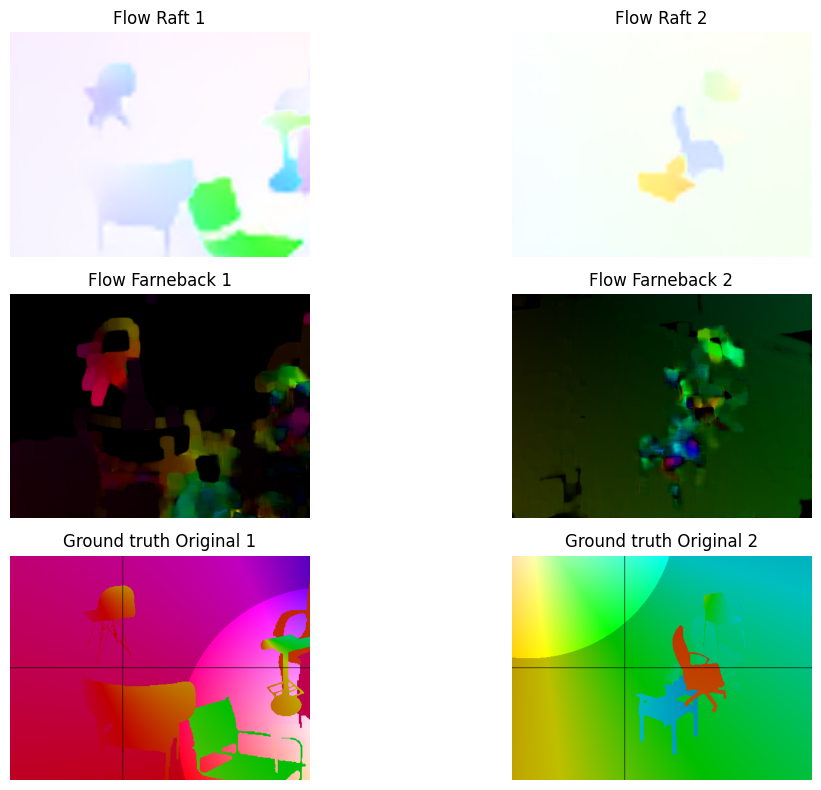

In [53]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

for i in range(2):
    axes[0, i].imshow(flow_imgs_cpu[i].permute(1, 2, 0))
    axes[0, i].set_title(f'Flow Raft {i+1}')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(flow_images_farneback[i])
    axes[1, i].set_title(f'Flow Farneback {i+1}')
    axes[1, i].axis('off')

    axes[2, i].imshow(flow_images_original[i])
    axes[2, i].set_title(f'Ground truth Original {i+1}')
    axes[2, i].axis('off')
    

plt.tight_layout()
plt.show()

Como se observa, la imagen generada por RAFT tiene una notable similitud con el Ground Truth. Las sillas que comparten el mismo color en la dirección del desplazamiento verdadero también presentan los mismos colores en RAFT. Sin embargo, RAFT muestra dificultades para detectar detalles más finos, como los reposabrazos, las ruedas o las patas de las sillas. A pesar de que la imagen aparece algo borrosa, las estimaciones en general son bastante aceptables.

En cuanto a Farneback, aunque es capaz de resaltar las formas de los objetos en movimiento, presenta dificultades para identificar los colores que indican la dirección del desplazamiento. Solo se logran ver los contornos borrosos de los objetos desplazados y los colores parecen estar mezclados, especialmente en la segunda imagen. Sin embargo, en la imagen 00001, la silla en la esquina superior izquierda parece ser detectada correctamente. Esto sugiere que Farneback tiene dificultades cuando los objetos desplazados están cerca o alineados entre sí.

Por lo tanto, en este caso, podemos concluir que el enfoque basado en deep learning, como RAFT, ha mostrado un mejor rendimiento que Farneback debido a su capacidad para capturar detalles más finos y seguir con mayor precisión los desplazamientos de los objetos, incluso en situaciones complejas, como cuando los objetos están alineados.